*Семенов Кирилл, ИАД-3, 3 курс*

#Importing data and libraries

In [ ]:
import zipfile
import numpy as np
import pandas as pd
import os
import io
import tqdm
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import csv

In [ ]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:

#!mkdir .kaggle
import json
token = {"username":"kiryukhasemenov","key":"c9581a51a569e7fb1c5b0d886fd0cc95"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
! pip install kaggle --upgrade
!KAGGLE_USERNAME="kiryukhasemenov"
!KAGGLE_KEY="c9581a51a569e7fb1c5b0d886fd0cc95"
!kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.0)
100% 7.36G/7.37G [01:53<00:00, 120MB/s]
100% 7.37G/7.37G [01:53<00:00, 69.7MB/s]


In [ ]:
# open zip file, will read everything from it
zf = zipfile.ZipFile("train_simplified.zip")

In [ ]:
class_labels = list(map(lambda x: x.replace(".csv", ""), zf.namelist()))
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [ ]:
def get_eternal_csv_generator(fn, debug=False):
  while True:
    with io.TextIOWrapper(zf.open(fn)) as f:
      f.readline()  
      for line in csv.reader(f, delimiter=',', quotechar='"'):
        yield line[1], line[5]
        if debug:
          print(fn, "is done, starting from the beginning...")

In [ ]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        if debug:
          print("Random_indices = {} \n".format(random_indices))
          print()
          print("Random_generators = {} \n".format(generators[random_indices]))
          print()
        yield [next(gen) for gen in generators[random_indices]]

In [ ]:
import ast
from PIL import Image, ImageDraw

IMG_SIZE = 224

def draw_it(strokes, img_size=224):
    image = Image.new("P", (256, 256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((img_size, img_size))
    return np.array(image, dtype=np.uint8)

In [ ]:
def images_and_labels_generator(batch_size, img_size=224):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0], img_size))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

100it [00:02, 45.30it/s]

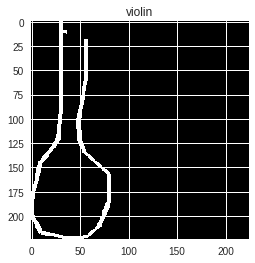

150it [00:03, 47.32it/s]

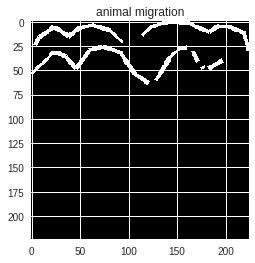

428it [00:09, 48.59it/s]

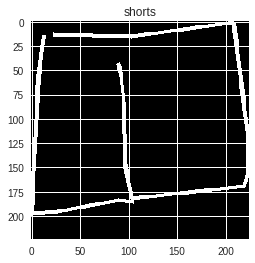

511it [00:11, 49.50it/s]

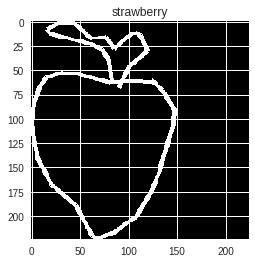

681it [00:15, 48.42it/s]

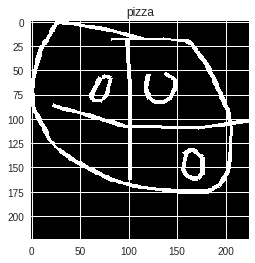

906it [00:20, 46.29it/s]

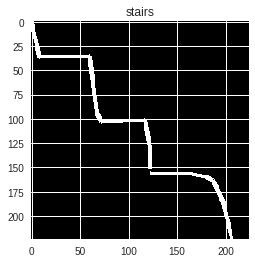

946it [00:21, 45.36it/s]

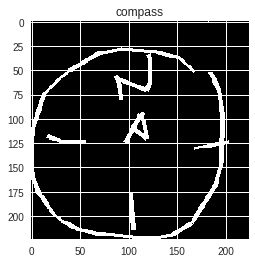

1006it [00:22, 47.10it/s]

KeyboardInterrupt: ignored

In [ ]:
# test
for batch in tqdm.tqdm(images_and_labels_generator(batch_size=32, img_size=IMG_SIZE)):
    if np.random.random() < 0.01:
        plt.imshow(batch[0][10, :, :])
        plt.title(batch[1][10])
        plt.show()

#training

In [ ]:
import tensorflow as tf
import keras
from keras import backend as K

Using TensorFlow backend.


In [ ]:
def reset_tf_session():
    curr_session = tf.get_default_session()
    if curr_session is not None:
        curr_session.close()
    K.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [ ]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}


In [ ]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}

def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images / 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(list(map(class_to_idx.get, batch[1])), NUM_CLASSES)
        yield images, labels

In [ ]:
sample = next(train_iterator(10))
print(sample[0].shape)
print(sample[1].shape)

(10, 224, 224, 1)
(10, 340)


In [ ]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,  \
    Dropout, AveragePooling2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D 

In [ ]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding = 'same',
    input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='elu')) 
    model.add(Conv2D(32, (5, 5), padding = 'same')) 
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
    model.add(Conv2D(32, (4, 4), padding = 'same')) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (4, 4), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (2, 2), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) 
    model.add(Dense(400)) 
    model.add(LeakyReLU(0.1))
    model.add(Dense(NUM_CLASSES, activation='softmax')) 
    
    return model

In [ ]:
s = reset_tf_session() 
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
__________

###setting metrics and everything useful for saving

In [ ]:
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [ ]:
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

###setting hyperparameters, which are the same for all models

In [ ]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = 100
EPOCHS = 64

last_finished_epoch = 0

In [ ]:
s = reset_tf_session()  
model = make_model()  

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.), 
    metrics=[categorical_accuracy, top_3_accuracy]  
)

In [ ]:
import os
GOOGLE_DRIVE_ROOT = GOOGLE_DRIVE_MOUNT + "/" + filter(lambda x: x[0] != '.', os.listdir(GOOGLE_DRIVE_MOUNT))[0]
print (GOOGLE_DRIVE_ROOT)

# will save checkpoints to Google Drive
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/model_{}"
print (CHECKPOINT_TEMPLATE)

TypeError: ignored

In [ ]:
history_baseline = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/64
100/100 [==============================] - 58s 576ms/step - loss: 5.6572 - categorical_accuracy: 0.0163 - top_3_accuracy: 0.0362
Model saved in model_0
Epoch 2/64
100/100 [==============================] - 51s 510ms/step - loss: 4.9405 - categorical_accuracy: 0.0667 - top_3_accuracy: 0.1392
Model saved in model_1
Epoch 3/64
100/100 [==============================] - 51s 510ms/step - loss: 4.3602 - categorical_accuracy: 0.1378 - top_3_accuracy: 0.2509
Model saved in model_2
Epoch 4/64
100/100 [==============================] - 51s 510ms/step - loss: 3.9084 - categorical_accuracy: 0.1939 - top_3_accuracy: 0.3384
Model saved in model_3
Epoch 5/64
100/100 [==============================] - 51s 510ms/step - loss: 3.6296 - categorical_accuracy: 0.2323 - top_3_accuracy: 0.3983
Model saved in model_4
Epoch 6/64
100/100 [==============================] - 51s 509ms/step - loss: 3.3993 - categorical_accuracy: 0.2714 - top_3_accuracy: 0.4522
Model saved in model_5
Epoch 7/64
100/100 [==

#Experiments with dropout and BatchNorm

###no dropout:

In [ ]:
def model_2():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding = 'same',
    input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='elu')) 
    model.add(Conv2D(32, (5, 5), padding = 'same')) 
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
    model.add(Conv2D(32, (4, 4), padding = 'same')) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (4, 4), padding = 'same')) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (2, 2), padding = 'same')) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) 
    model.add(Dense(400)) 
    model.add(LeakyReLU(0.1))
    model.add(Dense(NUM_CLASSES, activation='softmax')) 
    
    return model

s = reset_tf_session()  
model2 = model_2()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
__________

In [ ]:
model2.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  
    metrics=[categorical_accuracy, top_3_accuracy]  
)


history_model2 = model2.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/64
100/100 [==============================] - 56s 556ms/step - loss: 5.5035 - categorical_accuracy: 0.0330 - top_3_accuracy: 0.0708
Model saved in model_0
Epoch 2/64
100/100 [==============================] - 51s 509ms/step - loss: 4.6348 - categorical_accuracy: 0.1075 - top_3_accuracy: 0.1970
Model saved in model_1
Epoch 3/64
100/100 [==============================] - 51s 511ms/step - loss: 3.9883 - categorical_accuracy: 0.1789 - top_3_accuracy: 0.3258
Model saved in model_2
Epoch 4/64
100/100 [==============================] - 51s 510ms/step - loss: 3.6901 - categorical_accuracy: 0.2286 - top_3_accuracy: 0.3878
Model saved in model_3
Epoch 5/64
100/100 [==============================] - 51s 510ms/step - loss: 3.4164 - categorical_accuracy: 0.2711 - top_3_accuracy: 0.4411
Model saved in model_4
Epoch 6/64
100/100 [==============================] - 51s 510ms/step - loss: 3.2072 - categorical_accuracy: 0.3039 - top_3_accuracy: 0.4936
Model saved in model_5
Epoch 7/64
100/100 [==

###dropout = 0.01, no BatchNorm:

In [ ]:
def model_3():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding = 'same',
    input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='elu')) 
    model.add(Conv2D(32, (5, 5), padding = 'same')) 
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
    model.add(Conv2D(32, (4, 4), padding = 'same')) 
    model.add(Dropout(0.1))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (4, 4), padding = 'same')) 
    model.add(Dropout(0.1))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(Dropout(0.1))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(Dropout(0.1))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (2, 2), padding = 'same')) 
    model.add(Dropout(0.1))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) 
    model.add(Dense(400)) 
    model.add(LeakyReLU(0.1))
    model.add(Dense(NUM_CLASSES, activation='softmax')) 
    
    return model

s = reset_tf_session()  
model3 = model_3()
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      16416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
__________

In [ ]:

model3.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  
    metrics=[categorical_accuracy, top_3_accuracy]  
)


history_model3 = model3.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/64
100/100 [==============================] - 52s 516ms/step - loss: 5.6583 - categorical_accuracy: 0.0111 - top_3_accuracy: 0.0333
Model saved in model_0
Epoch 2/64
100/100 [==============================] - 51s 509ms/step - loss: 5.0061 - categorical_accuracy: 0.0666 - top_3_accuracy: 0.1356
Model saved in model_1
Epoch 3/64
100/100 [==============================] - 51s 510ms/step - loss: 4.3776 - categorical_accuracy: 0.1322 - top_3_accuracy: 0.2534
Model saved in model_2
Epoch 4/64
100/100 [==============================] - 51s 510ms/step - loss: 3.8704 - categorical_accuracy: 0.1994 - top_3_accuracy: 0.3572
Model saved in model_3
Epoch 5/64
100/100 [==============================] - 51s 509ms/step - loss: 3.5962 - categorical_accuracy: 0.2437 - top_3_accuracy: 0.4081
Model saved in model_4
Epoch 6/64
100/100 [==============================] - 51s 510ms/step - loss: 3.4097 - categorical_accuracy: 0.2737 - top_3_accuracy: 0.4455
Model saved in model_5
Epoch 7/64
100/100 [==

###dropout = 0.4, no BatchNorm

In [ ]:
def model_4():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding = 'same',
    input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='elu')) 
    model.add(Conv2D(32, (5, 5), padding = 'same')) 
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
    model.add(Conv2D(32, (4, 4), padding = 'same')) 
    model.add(Dropout(0.1))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (4, 4), padding = 'same')) 
    model.add(Dropout(0.1))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(Dropout(0.1))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(Dropout(0.1))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (2, 2), padding = 'same')) 
    model.add(Dropout(0.1))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) 
    model.add(Dense(400)) 
    model.add(LeakyReLU(0.1))
    model.add(Dense(NUM_CLASSES, activation='softmax')) 
    
    return model

s = reset_tf_session()  
model4 = model_4()
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      16416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
__________

In [ ]:
model4.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  
    metrics=[categorical_accuracy, top_3_accuracy]  
)



history_model4 = model4.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/64
100/100 [==============================] - 52s 517ms/step - loss: 5.6564 - categorical_accuracy: 0.0131 - top_3_accuracy: 0.0330
Model saved in model_0
Epoch 2/64
100/100 [==============================] - 51s 510ms/step - loss: 4.9457 - categorical_accuracy: 0.0623 - top_3_accuracy: 0.1384
Model saved in model_1
Epoch 3/64
100/100 [==============================] - 51s 510ms/step - loss: 4.3798 - categorical_accuracy: 0.1239 - top_3_accuracy: 0.2475
Model saved in model_2
Epoch 4/64
100/100 [==============================] - 51s 508ms/step - loss: 3.9580 - categorical_accuracy: 0.1877 - top_3_accuracy: 0.3391
Model saved in model_3
Epoch 5/64
100/100 [==============================] - 51s 509ms/step - loss: 3.6226 - categorical_accuracy: 0.2383 - top_3_accuracy: 0.4016
Model saved in model_4
Epoch 6/64
100/100 [==============================] - 51s 509ms/step - loss: 3.3672 - categorical_accuracy: 0.2695 - top_3_accuracy: 0.4473
Model saved in model_5
Epoch 7/64
100/100 [==

##comparison

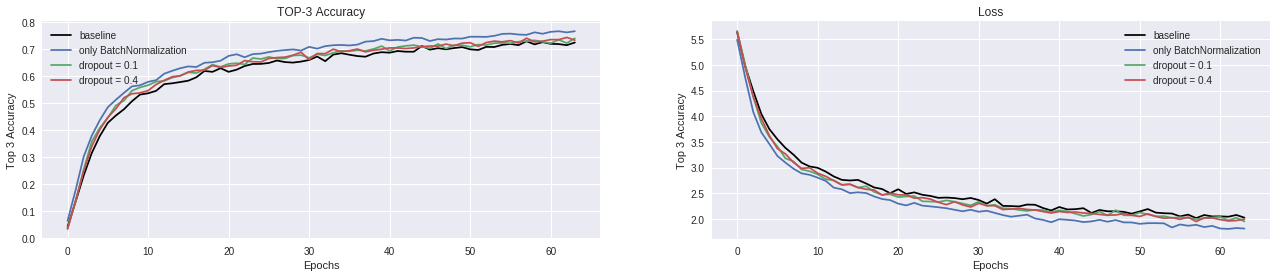

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(22, 4),
    sharey = False
)

ax1.set_title('TOP-3 Accuracy')
ax1.plot(history_baseline.history['top_3_accuracy'], color = 'black')
ax1.plot(history_model2.history['top_3_accuracy'])
ax1.plot(history_model3.history['top_3_accuracy'])
ax1.plot(history_model4.history['top_3_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Top 3 Accuracy')
ax1.legend(['baseline', 'only BatchNormalization', 'dropout = 0.1', 'dropout = 0.4'], loc='upper left')

ax2.set_title('Loss')
ax2.plot(history_baseline.history['loss'], color = 'black')
ax2.plot(history_model2.history['loss'])
ax2.plot(history_model3.history['loss'])
ax2.plot(history_model4.history['loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Top 3 Accuracy')
ax2.legend(['baseline', 'only BatchNormalization', 'dropout = 0.1', 'dropout = 0.4'], loc='upper right')


plt.show()

**the graphs show us that:** 

*   the best algorythm is the one with only ButchNormalization layers with no dropout.
*   Different dropout ratest show similar results.



#Other architectures

###same architecture, only average poolings

In [ ]:
def model_5():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding = 'same',
    input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='elu')) 
    model.add(Conv2D(32, (5, 5), padding = 'same')) 
    model.add(LeakyReLU(0.1))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2))) 
    model.add(Conv2D(32, (4, 4), padding = 'same')) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(AveragePooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (4, 4), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(AveragePooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (2, 2), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten()) 
    model.add(Dense(400)) 
    model.add(LeakyReLU(0.1))
    model.add(Dense(NUM_CLASSES, activation='softmax')) 

 
    
    return model

s = reset_tf_session()  
model5 = model_5()
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
__________

In [ ]:
model5.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.), 
    metrics=[categorical_accuracy, top_3_accuracy]  
)

history_model5 = model5.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/64
100/100 [==============================] - 57s 568ms/step - loss: 5.4388 - categorical_accuracy: 0.0328 - top_3_accuracy: 0.0739
Model saved in model_0
Epoch 2/64
100/100 [==============================] - 51s 507ms/step - loss: 4.5797 - categorical_accuracy: 0.1106 - top_3_accuracy: 0.2091
Model saved in model_1
Epoch 3/64
100/100 [==============================] - 51s 507ms/step - loss: 4.0277 - categorical_accuracy: 0.1875 - top_3_accuracy: 0.3252
Model saved in model_2
Epoch 4/64
100/100 [==============================] - 51s 508ms/step - loss: 3.7091 - categorical_accuracy: 0.2266 - top_3_accuracy: 0.3967
Model saved in model_3
Epoch 5/64
100/100 [==============================] - 51s 507ms/step - loss: 3.4513 - categorical_accuracy: 0.2592 - top_3_accuracy: 0.4380
Model saved in model_4
Epoch 6/64
100/100 [==============================] - 51s 507ms/step - loss: 3.3055 - categorical_accuracy: 0.2898 - top_3_accuracy: 0.4680
Model saved in model_5
Epoch 7/64
100/100 [==

###more "radical" poolings, default padding => less convolution layers

In [ ]:
def model_6():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
    input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='elu')) 
    model.add(Conv2D(32, (5, 5))) 
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2))) 
    model.add(Conv2D(32, (4, 4))) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3, 3))) 
    model.add(Conv2D(64, (4, 4))) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(3, 3))) 
    model.add(Conv2D(64, (2, 2))) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) 
    model.add(Dense(400)) 
    model.add(LeakyReLU(0.1))
    model.add(Dense(NUM_CLASSES, activation='softmax')) 
    
    return model

s = reset_tf_session()  
model6 = model_6()
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 32)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 216, 216, 32)      25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 216, 216, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 107, 107, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 104, 104, 32)      16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 104, 104, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 104, 104, 32)      0         
__________

In [ ]:
model6.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  
    metrics=[categorical_accuracy, top_3_accuracy] 
)



history_model6 = model6.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/64
100/100 [==============================] - 47s 471ms/step - loss: 5.6762 - categorical_accuracy: 0.0178 - top_3_accuracy: 0.0400
Model saved in model_0
Epoch 2/64
100/100 [==============================] - 44s 443ms/step - loss: 4.9481 - categorical_accuracy: 0.0778 - top_3_accuracy: 0.1591
Model saved in model_1
Epoch 3/64
100/100 [==============================] - 44s 442ms/step - loss: 4.4735 - categorical_accuracy: 0.1383 - top_3_accuracy: 0.2413
Model saved in model_2
Epoch 4/64
100/100 [==============================] - 44s 442ms/step - loss: 4.1970 - categorical_accuracy: 0.1608 - top_3_accuracy: 0.2927
Model saved in model_3
Epoch 5/64
100/100 [==============================] - 44s 442ms/step - loss: 3.9146 - categorical_accuracy: 0.2039 - top_3_accuracy: 0.3506
Model saved in model_4
Epoch 6/64
100/100 [==============================] - 44s 442ms/step - loss: 3.7377 - categorical_accuracy: 0.2236 - top_3_accuracy: 0.3817
Model saved in model_5
Epoch 7/64
100/100 [==

###one more convolutional layer, no flattening

In [ ]:
def model_7():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding = 'same',
    input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='elu')) 
    model.add(Conv2D(32, (5, 5), padding = 'same')) 
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
    model.add(Conv2D(32, (4, 4), padding = 'same')) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(32, (4, 4), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(32, (3, 3), padding = 'same')) 
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (2, 2), padding = 'same')) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (2, 2), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(500)) 
    model.add(LeakyReLU(0.1))
    model.add(Dense(NUM_CLASSES, activation='softmax')) 

    
    return model

s = reset_tf_session() 
model7 = model_7()
model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
__________

In [ ]:
model7.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  
    metrics=[categorical_accuracy, top_3_accuracy]  
)


history_model7 = model7.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/64
100/100 [==============================] - 50s 495ms/step - loss: 5.6438 - categorical_accuracy: 0.0116 - top_3_accuracy: 0.0263
Model saved in model_0
Epoch 2/64
100/100 [==============================] - 48s 485ms/step - loss: 5.1638 - categorical_accuracy: 0.0267 - top_3_accuracy: 0.0652
Model saved in model_1
Epoch 3/64
100/100 [==============================] - 49s 485ms/step - loss: 4.9021 - categorical_accuracy: 0.0470 - top_3_accuracy: 0.1086
Model saved in model_2
Epoch 4/64
100/100 [==============================] - 48s 485ms/step - loss: 4.7287 - categorical_accuracy: 0.0584 - top_3_accuracy: 0.1305
Model saved in model_3
Epoch 5/64
100/100 [==============================] - 49s 485ms/step - loss: 4.5802 - categorical_accuracy: 0.0764 - top_3_accuracy: 0.1663
Model saved in model_4
Epoch 6/64
100/100 [==============================] - 48s 485ms/step - loss: 4.4098 - categorical_accuracy: 0.0919 - top_3_accuracy: 0.2106
Model saved in model_5
Epoch 7/64
100/100 [==

##comparison

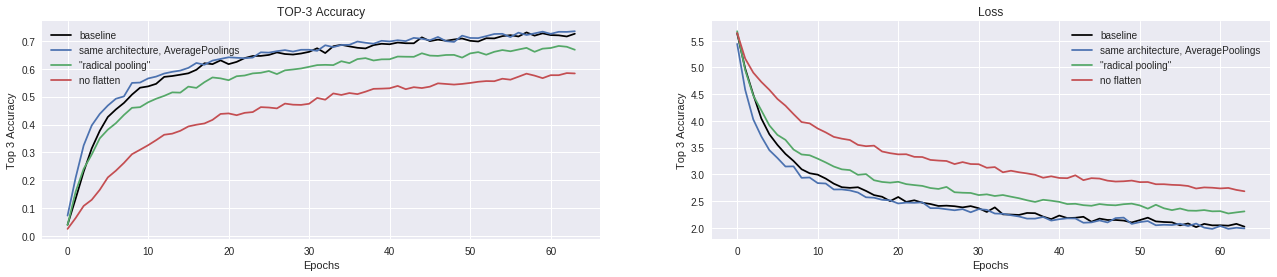

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(22, 4),
    sharey = False
)

ax1.set_title('TOP-3 Accuracy')
ax1.plot(history_baseline.history['top_3_accuracy'], color = 'black')
ax1.plot(history_model5.history['top_3_accuracy'])
ax1.plot(history_model6.history['top_3_accuracy'])
ax1.plot(history_model7.history['top_3_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Top 3 Accuracy')
ax1.legend(['baseline', 'same architecture, AveragePoolings', '"radical pooling"', 'no flatten'], loc='upper left')

ax2.set_title('Loss')
ax2.plot(history_baseline.history['loss'], color = 'black')
ax2.plot(history_model5.history['loss'])
ax2.plot(history_model6.history['loss'])
ax2.plot(history_model7.history['loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Top 3 Accuracy')
ax2.legend(['baseline', 'same architecture, AveragePoolings', '"radical pooling"', 'no flatten'], loc='upper right')


plt.show()

**The plots above show that:** 

*   average poolings show similar (or even a little better) result in the case of the same architectures. 
*   The poolings with 3x3 pool size show worse results than 2x2 poolings.
*   The flattening layer is very important, as its absence lowers all the rates significantly.


#Work with augmentation

###minimal augmentation

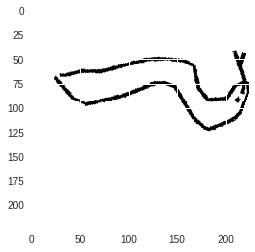

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
#b = list(images_and_labels_generator(10))

image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    cval=255
)

def aug_gen(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            img = draw_it(e[0])
            img = np.tile(np.expand_dims(img, axis=2), (1, 1, 3))
            img = image_gen.random_transform(img)
            batch_images.append(img)
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels


b = next(aug_gen(32))

plt.imshow(b[0][10, :, :])

In [ ]:
def aug_train_iterator(batch_size):
    for batch in aug_gen(batch_size):
        images = batch[0].astype('float32')
        images = images / 255 - 0.5
        labels = keras.utils.to_categorical(list(map(class_to_idx.get, batch[1])), NUM_CLASSES)
        yield images, labels

In [ ]:
def model8():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding = 'same',
    input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='elu')) 
    model.add(Conv2D(32, (5, 5), padding = 'same')) 
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
    model.add(Conv2D(32, (4, 4), padding = 'same')) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (4, 4), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same'))
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (2, 2), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) 
    model.add(Dense(400)) 
    model.add(LeakyReLU(0.1))
    model.add(Dense(NUM_CLASSES, activation='softmax')) 
    
    
    return model

s = reset_tf_session()
model8 = model8()
model8.summary()

model8.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
__________

In [ ]:

history_model8 = model8.fit_generator(
    aug_train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/64
100/100 [==============================] - 94s 941ms/step - loss: 5.7306 - categorical_accuracy: 0.0092 - top_3_accuracy: 0.0273
Epoch 2/64
100/100 [==============================] - 92s 919ms/step - loss: 5.2791 - categorical_accuracy: 0.0294 - top_3_accuracy: 0.0753
Epoch 3/64
100/100 [==============================] - 92s 921ms/step - loss: 5.0382 - categorical_accuracy: 0.0498 - top_3_accuracy: 0.1152
Epoch 4/64
100/100 [==============================] - 92s 922ms/step - loss: 4.8492 - categorical_accuracy: 0.0650 - top_3_accuracy: 0.1403
Epoch 5/64
100/100 [==============================] - 92s 917ms/step - loss: 4.6293 - categorical_accuracy: 0.0880 - top_3_accuracy: 0.1814
Epoch 6/64
100/100 [==============================] - 91s 911ms/step - loss: 4.5269 - categorical_accuracy: 0.0998 - top_3_accuracy: 0.2106
Epoch 7/64
100/100 [==============================] - 91s 913ms/step - loss: 4.3983 - categorical_accuracy: 0.1195 - top_3_accuracy: 0.2366
Epoch 8/64
100/100 [

###more rotation range

In [ ]:
image_gen = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    cval=255
)

In [ ]:
def model9():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding = 'same',
    input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='elu')) 
    model.add(Conv2D(32, (5, 5), padding = 'same')) 
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
    model.add(Conv2D(32, (4, 4), padding = 'same')) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (4, 4), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (2, 2), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) 
    model.add(Dense(400)) 
    model.add(LeakyReLU(0.1))
    model.add(Dense(NUM_CLASSES, activation='softmax')) 
    
    
    return model

s = reset_tf_session()
model9 = model9()
model9.summary()

model9.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
__________

In [ ]:
history_model9 = model9.fit_generator(
    aug_train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/64
100/100 [==============================] - 93s 928ms/step - loss: 5.8203 - categorical_accuracy: 0.0064 - top_3_accuracy: 0.0194
Epoch 2/64
100/100 [==============================] - 92s 923ms/step - loss: 5.5307 - categorical_accuracy: 0.0187 - top_3_accuracy: 0.0477
Epoch 3/64
100/100 [==============================] - 92s 923ms/step - loss: 5.3390 - categorical_accuracy: 0.0245 - top_3_accuracy: 0.0630
Epoch 4/64
100/100 [==============================] - 92s 924ms/step - loss: 5.2492 - categorical_accuracy: 0.0312 - top_3_accuracy: 0.0792
Epoch 5/64
100/100 [==============================] - 92s 923ms/step - loss: 5.0967 - categorical_accuracy: 0.0473 - top_3_accuracy: 0.1033
Epoch 6/64
100/100 [==============================] - 92s 924ms/step - loss: 5.0262 - categorical_accuracy: 0.0495 - top_3_accuracy: 0.1158
Epoch 7/64
100/100 [==============================] - 92s 921ms/step - loss: 4.9441 - categorical_accuracy: 0.0592 - top_3_accuracy: 0.1253
Epoch 8/64
100/100 [

###more features of augmentation

In [ ]:
image_gen = ImageDataGenerator(
    rotation_range=40,
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    width_shift_range=0.2,
    height_shift_range=0.2,
    cval=255
)

In [ ]:
def model10():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding = 'same',
    input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='elu')) 
    model.add(Conv2D(32, (5, 5), padding = 'same')) 
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) 
    model.add(Conv2D(32, (4, 4), padding = 'same')) 
    model.add(BatchNormalization()) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (4, 4), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (2, 2), padding = 'same')) 
    model.add(Dropout(0.25))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) 
    model.add(Dense(400)) 
    model.add(LeakyReLU(0.1))
    model.add(Dense(NUM_CLASSES, activation='softmax')) 
    
    
    return model

s = reset_tf_session()
model10 = model10()
model10.summary()

model10.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
__________

In [ ]:
history_model10 = model10.fit_generator(
    aug_train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/64
100/100 [==============================] - 90s 896ms/step - loss: 5.8073 - categorical_accuracy: 0.0070 - top_3_accuracy: 0.0227
Epoch 2/64
100/100 [==============================] - 89s 893ms/step - loss: 5.5153 - categorical_accuracy: 0.0169 - top_3_accuracy: 0.0431
Epoch 3/64
100/100 [==============================] - 89s 892ms/step - loss: 5.3887 - categorical_accuracy: 0.0219 - top_3_accuracy: 0.0564
Epoch 4/64
100/100 [==============================] - 89s 893ms/step - loss: 5.2650 - categorical_accuracy: 0.0297 - top_3_accuracy: 0.0747
Epoch 5/64
100/100 [==============================] - 89s 893ms/step - loss: 5.0979 - categorical_accuracy: 0.0439 - top_3_accuracy: 0.0989
Epoch 6/64
100/100 [==============================] - 89s 890ms/step - loss: 5.0383 - categorical_accuracy: 0.0500 - top_3_accuracy: 0.1169
Epoch 7/64
100/100 [==============================] - 89s 889ms/step - loss: 4.9320 - categorical_accuracy: 0.0584 - top_3_accuracy: 0.1250
Epoch 8/64
100/100 [

##comparison

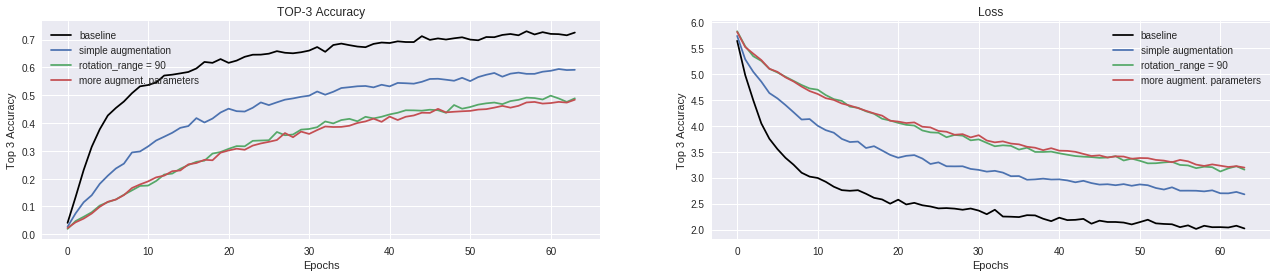

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(22, 4),
    sharey = False
)

ax1.set_title('TOP-3 Accuracy')
ax1.plot(history_baseline.history['top_3_accuracy'], color = 'black')
ax1.plot(history_model8.history['top_3_accuracy'])
ax1.plot(history_model9.history['top_3_accuracy'])
ax1.plot(history_model10.history['top_3_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Top 3 Accuracy')
ax1.legend(['baseline', 'simple augmentation', 'rotation_range = 90', 'more augment. parameters'], loc='upper left')

ax2.set_title('Loss')
ax2.plot(history_baseline.history['loss'], color = 'black')
ax2.plot(history_model8.history['loss'])
ax2.plot(history_model9.history['loss'])
ax2.plot(history_model10.history['loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Top 3 Accuracy')
ax2.legend(['baseline', 'simple augmentation', 'rotation_range = 90', 'more augment. parameters'], loc='upper right')


plt.show()

#Testing

In [ ]:
# download test set
!KAGGLE_USERNAME="kiryukhasemenov" KAGGLE_KEY="c9581a51a569e7fb1c5b0d886fd0cc95"
!kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

 83% 49.0M/59.0M [00:00<00:00, 26.8MB/s]
100% 59.0M/59.0M [00:00<00:00, 64.1MB/s]


In [ ]:
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_it(line[2]))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                batch_images = batch_images / 255 - 0.5
                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            batch_images = batch_images / 255 - 0.5
            yield batch_keys, batch_images

In [ ]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [ ]:
with open("submission.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        probas = model.predict_proba(batch_images, BATCH_SIZE)
        top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
        labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
        for key, labels in zip(batch_keys, labels):
            f.write(key + "," + labels + "\n")


  0%|          | 0/1754.0 [00:00<?, ?it/s]
  0%|          | 1/1754.0 [00:00<09:41,  3.02it/s]
  0%|          | 2/1754.0 [00:00<08:59,  3.25it/s]
  0%|          | 3/1754.0 [00:00<08:28,  3.44it/s]
  0%|          | 4/1754.0 [00:01<07:59,  3.65it/s]
  0%|          | 5/1754.0 [00:01<07:41,  3.79it/s]
  0%|          | 6/1754.0 [00:01<07:22,  3.95it/s]
  0%|          | 7/1754.0 [00:01<07:07,  4.08it/s]
  0%|          | 8/1754.0 [00:01<06:57,  4.18it/s]
  1%|          | 9/1754.0 [00:02<06:50,  4.25it/s]
  1%|          | 10/1754.0 [00:02<06:46,  4.29it/s]
  1%|          | 11/1754.0 [00:02<06:41,  4.34it/s]
  1%|          | 12/1754.0 [00:02<06:34,  4.41it/s]
  1%|          | 13/1754.0 [00:03<06:34,  4.41it/s]
  1%|          | 14/1754.0 [00:03<06:34,  4.42it/s]
  1%|          | 15/1754.0 [00:03<06:35,  4.40it/s]
  1%|          | 16/1754.0 [00:03<06:31,  4.43it/s]
  1%|          | 17/1754.0 [00:04<06:30,  4.44it/s]
  1%|          | 18/1754.0 [00:04<06:28,  4.46it/s]
  1%|          | 19/1754.0 [0

In [ ]:
! wc -l submission.csv

112200 submission.csv


In [ ]:
# submit to kaggle
! KAGGLE_USERNAME="kiryukhasemenov" KAGGLE_KEY="c9581a51a569e7fb1c5b0d886fd0cc95" kaggle competitions submit quickdraw-doodle-recognition -f submission.csv -m "My precious"

100% 4.40M/4.40M [00:09<00:00, 490kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge